In [30]:
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,Normalizer,QuantileTransformer
from keras.models import Model
from keras.layers import Dense,Input
from scipy.stats import *
from scipy.spatial.distance import *
from scipy.sparse.csgraph import laplacian
from numpy.linalg import eig
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import *
from sklearn.model_selection import cross_val_score
from sklearn.svm import *
from sklearn.neighbors import *
import pandas as pd
import hdbscan
from scipy.spatial.distance import *
from sklearn.decomposition import *
import keras.backend as K
from keras.optimizers import *
from keras.layers import Lambda,Dropout,Embedding
from keras.utils import multi_gpu_model
from keras import regularizers
from IPython.display import SVG
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score
from sklearn import metrics
# from DEC import DEC
import scipy.cluster.hierarchy as hc
from sklearn.metrics import *
from keras.utils.vis_utils import model_to_dot
import os
import seaborn as sns
from sklearn.manifold import TSNE,Isomap,LocallyLinearEmbedding
import umap
from scipy.cluster.hierarchy import *
from sklearn.cluster import *
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import matlab.engine
import matlab
import sys
sys.path.insert(0, '/home/yzy/software/DEC')



def numpy2mat(numpy_mat):
    list_mat = list(map(lambda x:list(x),numpy_mat))
    return matlab.double(list_mat)
os.environ["CUDA_VISIBLE_DEVICES"]="0"
# data_mat = sio.loadmat('/home/yzy/SIMS/0801liver_data.mat')
data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_0614_2.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_hunyang14_0827.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_0911_withlabel.mat')
# 3个batch，286dim，1:SIMS20180713/liver-cancer-1;2:
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_zuzhi_0918.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_0920.mat')

# 0928的混养，2个batch，无cell type，br和i在最后两列
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_0928hunyang_2batch.mat')

# 1001的混养数据，四类
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_1001cellline_4batch_last2dimbri.mat')

# data_mat = sio.loadmat('/home/yzy/SIMS/data_mat_fiber241_1023.mat')


# 1031的一个batch，三类混养
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_three_mix_withlabel_181031_231.mat')

# 1103的一个batch，lung-erxing组织
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_lung-erxing_1103_225.mat')

# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181106_mcf-7-high-spatial-resolution.mat')

# 1109的liver，highres，在两个不同的labelling下提取的datamat，223维
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181109_liver_highres_354&434cells_223dim.mat')



# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181111_liver_free&hoechst_181dim_new.mat')
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181111_liver_hoechst_blood_dim181_cell402.mat')

# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181111_liver_free_181dim_2labeling.mat')


# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181119_liver&lung_181.mat')

# lung的克拉拉细胞
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181126_lung_306.mat')

# lung的type2细胞
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181126_lung-type2_434_160dim.mat')

# batch1：cancer-idu_cancer-free,169dim,idu：1.
# batch2:cancer-idu_normal-free,169dim,idu:1
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_181130_cellline_cancer_169dims_1idu.mat')

# 小肠的数据，同一片，分别是大细胞和小细胞。
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_20181208_intestine_185_big_small.mat')

# intestine-1
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_20181208_intestine-1_194_small.mat')

# liver-alb,同一片，分别是大细胞和小细胞
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_20181208_liver-alb_193_big_small.mat')



# data_mat = sio.loadmat('/home/yzy/SIMS/0713liver_data.mat')

data_mat=data_mat['data_mat']

# num_features = 286
num_features = 274
# num_featuress = 225
# num_features = 191
# num_features=223
# num_features = 181
# num_features = 150
# num_features = 160
# num_features = 169
# num_features = 185
# num_features = 194
# num_features = 193
# num_features = 225
img_size = 256

def reset_weights(model):
    session = K.get_session()
#     k=0
    for layer in model.layers: 
#         print(k)
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
#             k+=1

def label2CM(label):
    label_sz = label.shape[0]
    rst = np.zeros(shape=(label_sz,label_sz))
    for i in range(label_sz):
        for j in range(i+1):
            if label[i]==label[j]:
                rst[i,j] = 1
                rst[j,i] = 1
    return rst
            
def get_matter_img(matter_idx,batch_num):
    data = batch_dict[batch_num]
    pos = pos_dict[batch_num]
    sorted_idx = np.argsort(pos)
    sorted_data = data[sorted_idx,matter_idx]
    return sorted_data.reshape((256,256))

def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]

def cal_square_dist(idx1,idx2,size):
    i1,j1=divmod(idx1-1,size)
    i1 +=1
    j1 +=1
    i2,j2=divmod(idx2-1,size)
    i2+=1
    j2+=1
    return (i1-i2)**2+(j1-j2)**2
def get_labeling(label,cell_idx):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b
    
    return labeling

In [88]:
data_mat[:,5]

array([-18.09404406, -17.55132084, -17.72810802, ..., -27.76690685,
       -27.85499532, -28.04798117])

In [31]:
data_mat.shape[1]

280

In [21]:
# 有label情况的处理

# 1.147 0.025
def get_train_data(batch_num_list,mode,norm):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4
    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
#         plt.plot(sort_val)
#         plt.show()


    #     train_x = train_x/np.percentile(train_x,80,axis=1,keepdims=True)
    #     train_x = np.log(train_x+1)


        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,80,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    
    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x
    
    return train_x,cell_idx,cell_type,cell_pos,batch_idx,num_cells



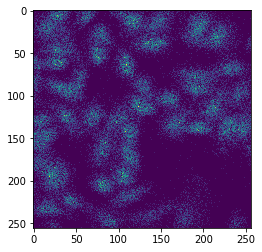

In [115]:
img =batch_dict[2][:,94+6][np.argsort(pos_dict[2])]
plt.imshow(img.reshape((256,256)))
plt.show()

In [175]:
# 无label的情况
from sklearn.metrics.pairwise import euclidean_distances
import pickle
batch_dict = {}
batch_dict_robust = {}
batch_dict_minmax = {}
batch_dict_standard = {}
batch_dict_134 = {}
batch_dict_norm = {}
batch_dict_norm_standard = {}
batch_dict_standard_norm = {}
label_dict = {}
cell_dict = {}
pos_dict = {}
cell_weight_dict = {}
FE_dict={}
for i in range(1):
    print(i)
    cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]
#     cur_data_134 = cur_data/cur_data[:,91][:,None]
#     cur_data_134 = cur_data/cur_data[:,96-2][:,None]
    cur_data_134 = cur_data/cur_data[:,93-2][:,None]

    cur_data_robust = RobustScaler().fit_transform(cur_data)
    cur_data_minmax = MinMaxScaler().fit_transform(cur_data)
    cur_data_standard = StandardScaler().fit_transform(cur_data)
    cur_data_norm = Normalizer().fit_transform(cur_data)
    cur_data_norm_standard = StandardScaler().fit_transform(cur_data_norm)
    cur_data_standard_norm = Normalizer().fit_transform(cur_data_standard)
    batch_dict[i+1] = cur_data
    batch_dict_134[i+1] = cur_data_134
    batch_dict_robust[i+1] = cur_data_robust
    batch_dict_minmax[i+1] = cur_data_minmax
    batch_dict_standard[i+1] = cur_data_standard
    batch_dict_norm[i+1] = cur_data_norm
    batch_dict_norm_standard[i+1] = cur_data_norm_standard
    batch_dict_standard_norm[i+1] = cur_data_standard_norm
    cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
    cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
    label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)
    
   
    pos_dict[i+1] = cur_batch_idx

0


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
# 有label的情况

from sklearn.metrics.pairwise import euclidean_distances
import pickle
batch_dict = {}
batch_dict_robust = {}
batch_dict_minmax = {}
batch_dict_standard = {}
batch_dict_134 = {}
batch_dict_norm = {}
batch_dict_norm_standard = {}
batch_dict_standard_norm = {}
label_dict = {}
cell_dict = {}
pos_dict = {}
cell_weight_dict = {}
FE_dict={}
for i in range(4):
    print(i)
    cur_data = data_mat[data_mat[:,0]==i+1,6:num_features+6]
    cur_data_134 = cur_data/cur_data[:,96-2][:,None]
    cur_data_robust = RobustScaler().fit_transform(cur_data)
    cur_data_minmax = MinMaxScaler().fit_transform(cur_data)
    cur_data_standard = StandardScaler().fit_transform(cur_data)
    cur_data_norm = Normalizer().fit_transform(cur_data)
    cur_data_norm_standard = StandardScaler().fit_transform(cur_data_norm)
    cur_data_standard_norm = Normalizer().fit_transform(cur_data_standard)
    batch_dict[i+1] = cur_data
    batch_dict_134[i+1] = cur_data_134
    batch_dict_robust[i+1] = cur_data_robust
    batch_dict_minmax[i+1] = cur_data_minmax
    batch_dict_standard[i+1] = cur_data_standard
    batch_dict_norm[i+1] = cur_data_norm
    batch_dict_norm_standard[i+1] = cur_data_norm_standard
    batch_dict_standard_norm[i+1] = cur_data_standard_norm
    label_dict[i+1] = data_mat[data_mat[:,0]==i+1,2]
    cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
    cur_batch_idx = data_mat[data_mat[:,0]==i+1,3]
#     FE_dict[i+1] = data_mat[data_mat[:,0]==i+1,4]
    pos_dict[i+1] = cur_batch_idx
#     cur_length = cur_data.shape[0]
#     cur_dist = np.zeros(shape=(cur_length,cur_length))
#     cur_ij_mat = np.zeros(shape=(cur_length,2))
#     for j in range(cur_length):
        
#         ii,jj=ind2ij(cur_batch_idx[j],img_size)
        
#         cur_ij_mat[j,0] = ii
#         cur_ij_mat[j,1] = jj
#     cur_dist = euclidean_distances(cur_ij_mat)
    
#     dist_dict[i+1] = cur_dist
# pickle.dump(dist_dict,open("/home/yzy/SIMS/eu_dist_dict_13.pkl","wb"))

0


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


1
2
3


In [40]:
import keras
from keras.constraints import *
from keras.regularizers import *
from keras.layers import *

from keras.initializers import *
activa = 'relu'
dp_rate = 0.5
low_dim = 128
l2_penalty = 0
l1_penalty = 1e-5
use_bias = False
def modi_softmax(args):
    t =1
    pixel_embed,nuclei_embed = args
    
    
    
    pixel_embed = pixel_embed[:,None]
#     pixel_embed = K.l2_normalize(pixel_embed,axis=-1)
#     nuclei_embed = K.l2_normalize(nuclei_embed,axis=-1)
    
    print('pixel_embed',pixel_embed.shape)
    print('nuclei_embed',nuclei_embed.shape)
    minus_square = (pixel_embed*nuclei_embed/t)
#     minus_square = K.square(pixel_embed-nuclei_embed)
    print('minus_square',minus_square.shape)
    
#     sum_minus_square = -K.sum(minus_square,axis=-1)/t
    sum_minus_square = K.sum(minus_square,axis=-1)
#     norm_exp = K.softmax(sum_minus_square)
    return sum_minus_square
    
#     print('norm_exp',norm_exp)
    
def modi_softeuc(args):
    t = 1
    p = 1
    pixel_embed,nuclei_embed = args
    
    
    
    pixel_embed = pixel_embed[:,None]
#     pixel_embed = K.l2_normalize(pixel_embed,axis=-1)
#     nuclei_embed = K.l2_normalize(nuclei_embed,axis=-1)
    
    print('pixel_embed',pixel_embed.shape)
    print('nuclei_embed',nuclei_embed.shape)
#     minus_square = (pixel_embed*nuclei_embed/t)
    minus_square = K.square(pixel_embed-nuclei_embed)
#     minus_square = K.abs(pixel_embed-nuclei_embed)

    print('minus_square',minus_square.shape)
    
#     sum_minus_square = -K.sqrt(K.sum(minus_square,axis=-1))/t
    sum_minus_square = -K.pow(K.sum(minus_square,axis=-1)/t,p)

#     sum_minus_square = K.sum(minus_square,axis=-1)
    norm_exp = K.softmax(sum_minus_square)
    return norm_exp
    
    print('norm_exp',norm_exp)
def cal_kld(nuclei_embed):
#     计算nuclei embed的arccos矩阵和均匀分布的kl散度
#     也就是arccos矩阵的熵
    pass

def cal_pl_loss(args):
    nuclei_embed,target,pixel_embed = args
#     target = K.expand_dims(target,axis=1)
#     print('nuclei_embed',nuclei_embed.shape)
#     print('target',target.shape)
    target = K.expand_dims(target,axis=1)
#     print('pixel_embed',pixel_embed.shape)
    print('nuclei_embed',nuclei_embed.shape)
    print('target',target.shape)
    aaa = K.batch_dot(target,nuclei_embed)
    print('aaa1',aaa.shape)
#     aaa = K.squeeze(aaa,2)
#     pixel_embed = K.squeeze(pixel_embed,1)
#     aaa = K.squeeze(aaa,1)
    pixel_embed = K.expand_dims(pixel_embed,axis=1)
    print('aaa',aaa.shape)
    print('pixel_embed',pixel_embed.shape)
    rst = K.sum(K.square(aaa-pixel_embed),axis=-1,keepdims=False)
    return rst
    
    
####################MLP################################################################################
SIMS_input = Input(shape=(train_x.shape[1],))
target_input = Input(shape=(1,))
dummy_input = Input(shape=(num_cells,))

d1 = Dense(512,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(SIMS_input)
# d1 = Dense(1024,activation=activa,kernel_initializer='random_uniform')(SIMS_input)
# d1 = Dense(1024,activation=activa,kernel_initializer='random_uniform')(d1)


d2 = Dense(256,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d1)
# d2 = Dense(512,activation=activa,kernel_initializer='random_uniform')(d1)
# d2 = Dense(512,activation=activa,kernel_initializer='random_uniform')(d2)
# d2 = Dense(256,activation='linear',kernel_initializer='random_uniform',use_bias=use_bias)(d2)


# d3 = Dense(64,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty))(d2)
# d3 = Dense(256,activation=activa,kernel_initializer='random_uniform')(d2)
# d3 = Dense(256,activation=activa,kernel_initializer='random_uniform')(d3)


d4 = Dense(low_dim,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d2)
# d4 = Dense(num_cells,activation='linear',kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d2)
####################MLP################################################################################
centerloss_embed_layer = Embedding(num_cells, low_dim)(target_input)
centerloss_out = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]), 1, keepdims=True), name='center')([d4,centerloss_embed_layer])


embed_layer = Embedding(num_cells,low_dim,input_length=num_cells,embeddings_initializer='random_uniform')(dummy_input)
normalized_logit_layer = Lambda(modi_softmax,name='normalized_logit_layer')([d4,embed_layer])


softmax_out = Activation('softmax',name='softmax')(normalized_logit_layer)

softmax_model = Model([SIMS_input,target_input,dummy_input],[softmax_out,centerloss_out])
softmax_model.compile(optimizer=sgd(),loss=['categorical_crossentropy',lambda y_true,y_pred:y_pred],loss_weights=[1,0])
onehot_label = keras.utils.to_categorical(cell_idx-1,num_cells)
reset_weights(softmax_model)
dummy_input_data = np.tile(np.arange(num_cells),(train_x.shape[0],1))

history=softmax_model.fit([train_x,cell_idx-1,dummy_input_data],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=50,shuffle=True,batch_size=64)




# target_input = Input(shape=(num_cells,))
# # embed_layer = Embedding(num_cells,2,input_length=num_cells,embeddings_initializer='random_uniform',embeddings_constraint=keras.constraints.min_max_norm(min_value=1, max_value=10, rate=1.0, axis=0))(dummy_input)
# embed_layer = Embedding(num_cells,low_dim,input_length=num_cells,embeddings_initializer='random_uniform')(dummy_input)

# # softmax_out = Lambda(modi_softmax)([d4,embed_layer])
# softmax_out = Lambda(modi_softmax,name='modified_softmax')([d4,embed_layer])

# centerloss_embed_layer = Embedding(num_cells, low_dim)(target_input)
# centerloss_out = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]), 1, keepdims=True), name='center_loss')([d4,centerloss_embed_layer])

# pl_loss_out = Lambda(cal_pl_loss,name='pl_loss')([embed_layer,target_input,d4])


# # softmax_out = Dense(num_cells,activation = 'softmax',kernel_initializer='random_uniform',kernel_constraint=unit_norm(),use_bias=False)(d4)
# # softmax_out = Dense(num_cells,activation = 'softmax',kernel_initializer='random_uniform')(d4)

# # d4 = Lambda(lambda  x: K.l2_normalize(x,axis=1))(d4)
# # softmax_out = Dense(num_cells,activation = 'softmax',kernel_initializer='random_uniform')(d4)


# #下面是euclidean based softmax



# classification_model_singlegpu = Model(inputs=[SIMS_input,dummy_input,target_input],outputs=[softmax_out,pl_loss_out])
# # classification_model = multi_gpu_model(classification_model_singlegpu,gpus=2)
# classification_model_singlegpu.compile(optimizer=nadam(),loss=['categorical_crossentropy',lambda y_true,y_pred: y_pred], loss_weights=[1.,0])

# onehot_label = keras.utils.to_categorical(cell_idx-1,num_cells)
# # onehot_label1 = onehot_label[:,None,:]
# print('onehot_label',onehot_label.shape)
# # classification_model.fit(train_x,onehot_label,epochs=200,shuffle=True,batch_size=128,sample_weight=cell_center_dist_exp)
# history=classification_model_singlegpu.fit([train_x,np.tile(np.arange(num_cells),(train_x.shape[0],1)),onehot_label],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=500,shuffle=True,batch_size=128)





pixel_embed (?, 1, 128)
nuclei_embed (?, 37, 128)
minus_square (?, 37, 128)
pixel_embed (?, 1, 128)
nuclei_embed (?, 37, 128)
minus_square (?, 37, 128)
Epoch 1/50
4582/4582 [==============================] - 3s 629us/step - loss: 3.4939 - softmax_loss: 3.4939 - center_loss: 582.4437
Epoch 2/50
4582/4582 [==============================] - 0s 109us/step - loss: 3.2793 - softmax_loss: 3.2793 - center_loss: 455.3013
Epoch 3/50
4582/4582 [==============================] - 0s 91us/step - loss: 3.1545 - softmax_loss: 3.1545 - center_loss: 522.3955
Epoch 4/50
4582/4582 [==============================] - 2s 351us/step - loss: 3.0522 - softmax_loss: 3.0522 - center_loss: 569.9889
Epoch 5/50
4582/4582 [==============================] - 2s 545us/step - loss: 2.9162 - softmax_loss: 2.9162 - center_loss: 629.2734
Epoch 6/50
4582/4582 [==============================] - 0s 85us/step - loss: 2.8620 - softmax_loss: 2.8620 - center_loss: 675.6102
Epoch 7/50
4582/4582 [==============================] - 0s

In [41]:
logit_model = Model([SIMS_input,dummy_input],normalized_logit_layer)
pred_logit = logit_model.predict([train_x,dummy_input_data])
cur_representation = np.exp(pred_logit/10)
cur_representation = cur_representation/np.sum(cur_representation,axis=1,keepdims=True)
cur_representation = np.transpose(cur_representation)

In [48]:
[train_x,cell_idx,cell_type,cell_pos,batch_idx,num_cells] = get_train_data([2],'none','none')
train_x_median = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)
mean_profile_list_median = []
for i in range(int(num_cells)):
    mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
mean_profile_list_median = np.array(mean_profile_list_median)

_,unique_idx = np.unique(cell_idx,return_index=True)
true_y = cell_type[unique_idx]
np.unique(true_y)



array([ 1.,  2.])

In [35]:
train_x_median

array([[ 3.21887582,  3.79548919,  3.51154544, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.86220088,  3.36729583,  3.51154544, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.89037176,  3.76120012,  3.19867312, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 3.27714473,  4.00733319,  3.52636052, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.55534806,  4.52178858,  3.91202301, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.80336038,  3.78418963,  3.314186  , ...,  0.        ,
         0.        ,  0.40546511]])

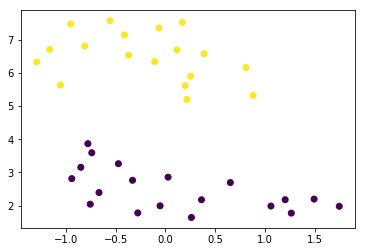

In [52]:
# cur_rep = mean_profile_list_median
cur_rep = cur_representation
embed_test = umap.UMAP(metric='euclidean').fit_transform(cur_rep)
pred_y = hdbscan.HDBSCAN().fit_predict(embed_test)
plt.scatter(embed_test[:,0],embed_test[:,1],c=pred_y)
plt.show()

In [63]:
labeling = get_labeling(pred_y,cell_idx)
labeling = labeling[:,0]

In [64]:
labeling.shape

(65536,)

In [61]:
batch_dict[2][np.argsort(pos_dict[2]),:].shape

(65536, 274)

In [65]:
multiplex = batch_dict[2][np.argsort(pos_dict[2])]
pixel_profile_median_dict = {}
# 按照pos拍过许的train_x
for label in np.unique(pred_y):
    label += 1
    cur_pixel_mat = multiplex[labeling==label,:]
    cur_pixel_mat_median = cur_pixel_mat/np.percentile(cur_pixel_mat,50,axis=1,keepdims=True)
    pixel_profile_median_dict[label] = cur_pixel_mat_median
    
    

In [69]:
for ind,val in pixel_profile_median_dict.items():
    print(ind)

1
2


In [138]:
corr_mat_dict = {}
for ind,cur_pixel_mat in pixel_profile_median_dict.items():
    cur_corr_mat = 1-squareform(pdist(np.transpose(cur_pixel_mat),metric='cosine'))
    corr_mat_dict[ind] = cur_corr_mat


In [89]:
matters_candidate = [50.73, 51.01, 51.02, 51.98, 51.99, 52.96, 52.98, 53.04, 54.01, 54.04, 56.02, 56.06, 57.02, 57.04, 60.0, 64.97, 64.99, 65.96, 66.97, 68.05, 69.04, 70.01, 70.97, 70.98, 71.93, 72.97, 73.05, 79.42, 81.05, 81.95, 81.99, 82.03, 82.97, 84.05, 85.04, 86.0, 87.06, 88.02, 88.97, 90.01, 91.03, 92.02, 93.01, 93.04, 93.99, 94.03, 95.03, 95.96, 96.01, 96.05, 96.93, 97.93, 97.97, 101.03, 104.01, 105.03, 105.97, 106.03, 106.99, 107.03, 108.02, 109.01, 109.04, 109.98, 110.03, 110.98, 111.02, 111.96, 112.96, 113.04, 113.97, 114.93, 114.99, 117.02, 118.03, 120.02, 121.04, 122.03, 123.02, 123.99, 124.04, 124.97, 125.04, 126.04, 126.96, 127.06, 127.95, 128.05, 128.95, 129.11, 130.95, 131.03, 132.03, 133.01, 134.05, 135.03, 136.01, 136.28, 142.07, 143.04, 143.95, 144.04, 145.04, 146.04, 146.95, 147.02, 148.03, 149.04, 149.88, 150.04, 150.89, 150.98, 151.05, 151.89, 151.95, 153.02, 153.96, 154.06, 154.94, 156.94, 157.04, 157.92, 158.05, 159.04, 160.04, 161.04, 162.04, 163.02, 164.04, 165.03, 165.91, 166.92, 167.94, 168.05, 168.94, 169.95, 170.07, 170.94, 171.96, 172.03, 172.96, 173.05, 174.04, 176.04, 178.03, 180.05, 182.06, 183.93, 184.94, 185.06, 185.92, 186.05, 186.92, 187.97, 188.05, 189.05, 190.04, 191.05, 192.05, 193.04, 194.06, 201.06, 201.9, 202.06, 202.91, 203.91, 204.05, 204.91, 205.05, 205.91, 206.05, 206.92, 207.04, 208.08, 208.92, 209.09, 209.94, 210.07, 210.93, 212.95, 213.9, 214.05, 216.05, 218.06, 221.06, 222.06, 223.89, 224.92, 225.92, 226.93, 228.9, 229.9, 230.85, 232.06, 232.87, 233.05, 233.87, 242.88, 243.9, 244.88, 245.89, 246.9, 247.89, 248.9, 249.91, 253.22, 254.86, 255.23, 256.24, 261.86, 262.88, 263.87, 264.88, 265.88, 266.87, 268.87, 269.89, 271.87, 281.25, 282.25, 282.86, 283.27, 284.86, 285.87, 287.88, 290.85, 291.84, 292.84, 293.83, 301.84, 302.85, 303.86, 304.86, 306.85, 308.84, 309.88, 314.82, 321.84, 322.84, 323.84, 324.84, 325.84, 333.82, 341.82, 342.83, 344.82, 346.83, 348.85, 350.8, 362.81, 363.82, 364.83, 365.83, 367.57, 380.79, 381.79, 382.8, 384.81, 386.81, 387.81, 402.79, 403.8, 404.8, 412.76, 424.78, 426.78, 433.75, 434.73, 440.75, 450.73, 455.73, 456.73, 464.75, 494.7]
len(matters_candidate)

274

In [129]:
corr_mat_dict[1][0,0]

1.0

In [124]:
np.argsort(plot_corr_mat[96,:])

array([ 96, 260, 272, 269, 261, 266, 271, 263, 255, 267, 270, 245, 273,
       244, 247, 254, 249, 256, 264, 265, 243, 262, 268, 259, 248, 250,
       213, 206, 258, 237, 242, 252, 239, 253, 224, 229, 246, 235, 227,
       225, 234, 231, 217, 222, 219, 223, 233, 251, 215, 236, 228, 216,
       257, 241, 238, 218, 232, 226, 221, 202, 230, 211, 214, 203, 181,
       196, 212, 185, 205, 200, 191, 204, 197, 207, 210, 193, 199, 220,
       189, 190, 175, 195, 198, 183, 176, 209, 240, 187, 208, 182, 184,
       180, 162, 192, 201, 173, 164, 194, 165, 155, 169, 170, 147, 168,
       186, 159, 171, 177, 167, 160, 172, 163, 178, 151, 154, 150, 138,
       174, 179, 133, 148, 166, 149, 141, 158, 188, 137, 161, 145, 132,
       156, 131, 152, 123, 143, 128, 157, 127, 120, 108, 146, 135, 110,
       119, 129, 136, 139, 153, 130, 125, 116, 121, 134, 122, 126, 124,
       102, 115, 118, 117, 144, 111,  91, 114, 103,  85, 140,  94,  90,
        61,  99,  83,  88, 107, 106, 100,  76, 142, 104, 105,  9

In [139]:
plot_corr_mat = np.triu(corr_mat_dict[1], k=0)+np.tril(corr_mat_dict[2], k=-1)

In [136]:
corr_mat_dict[1][0,0]

1.0

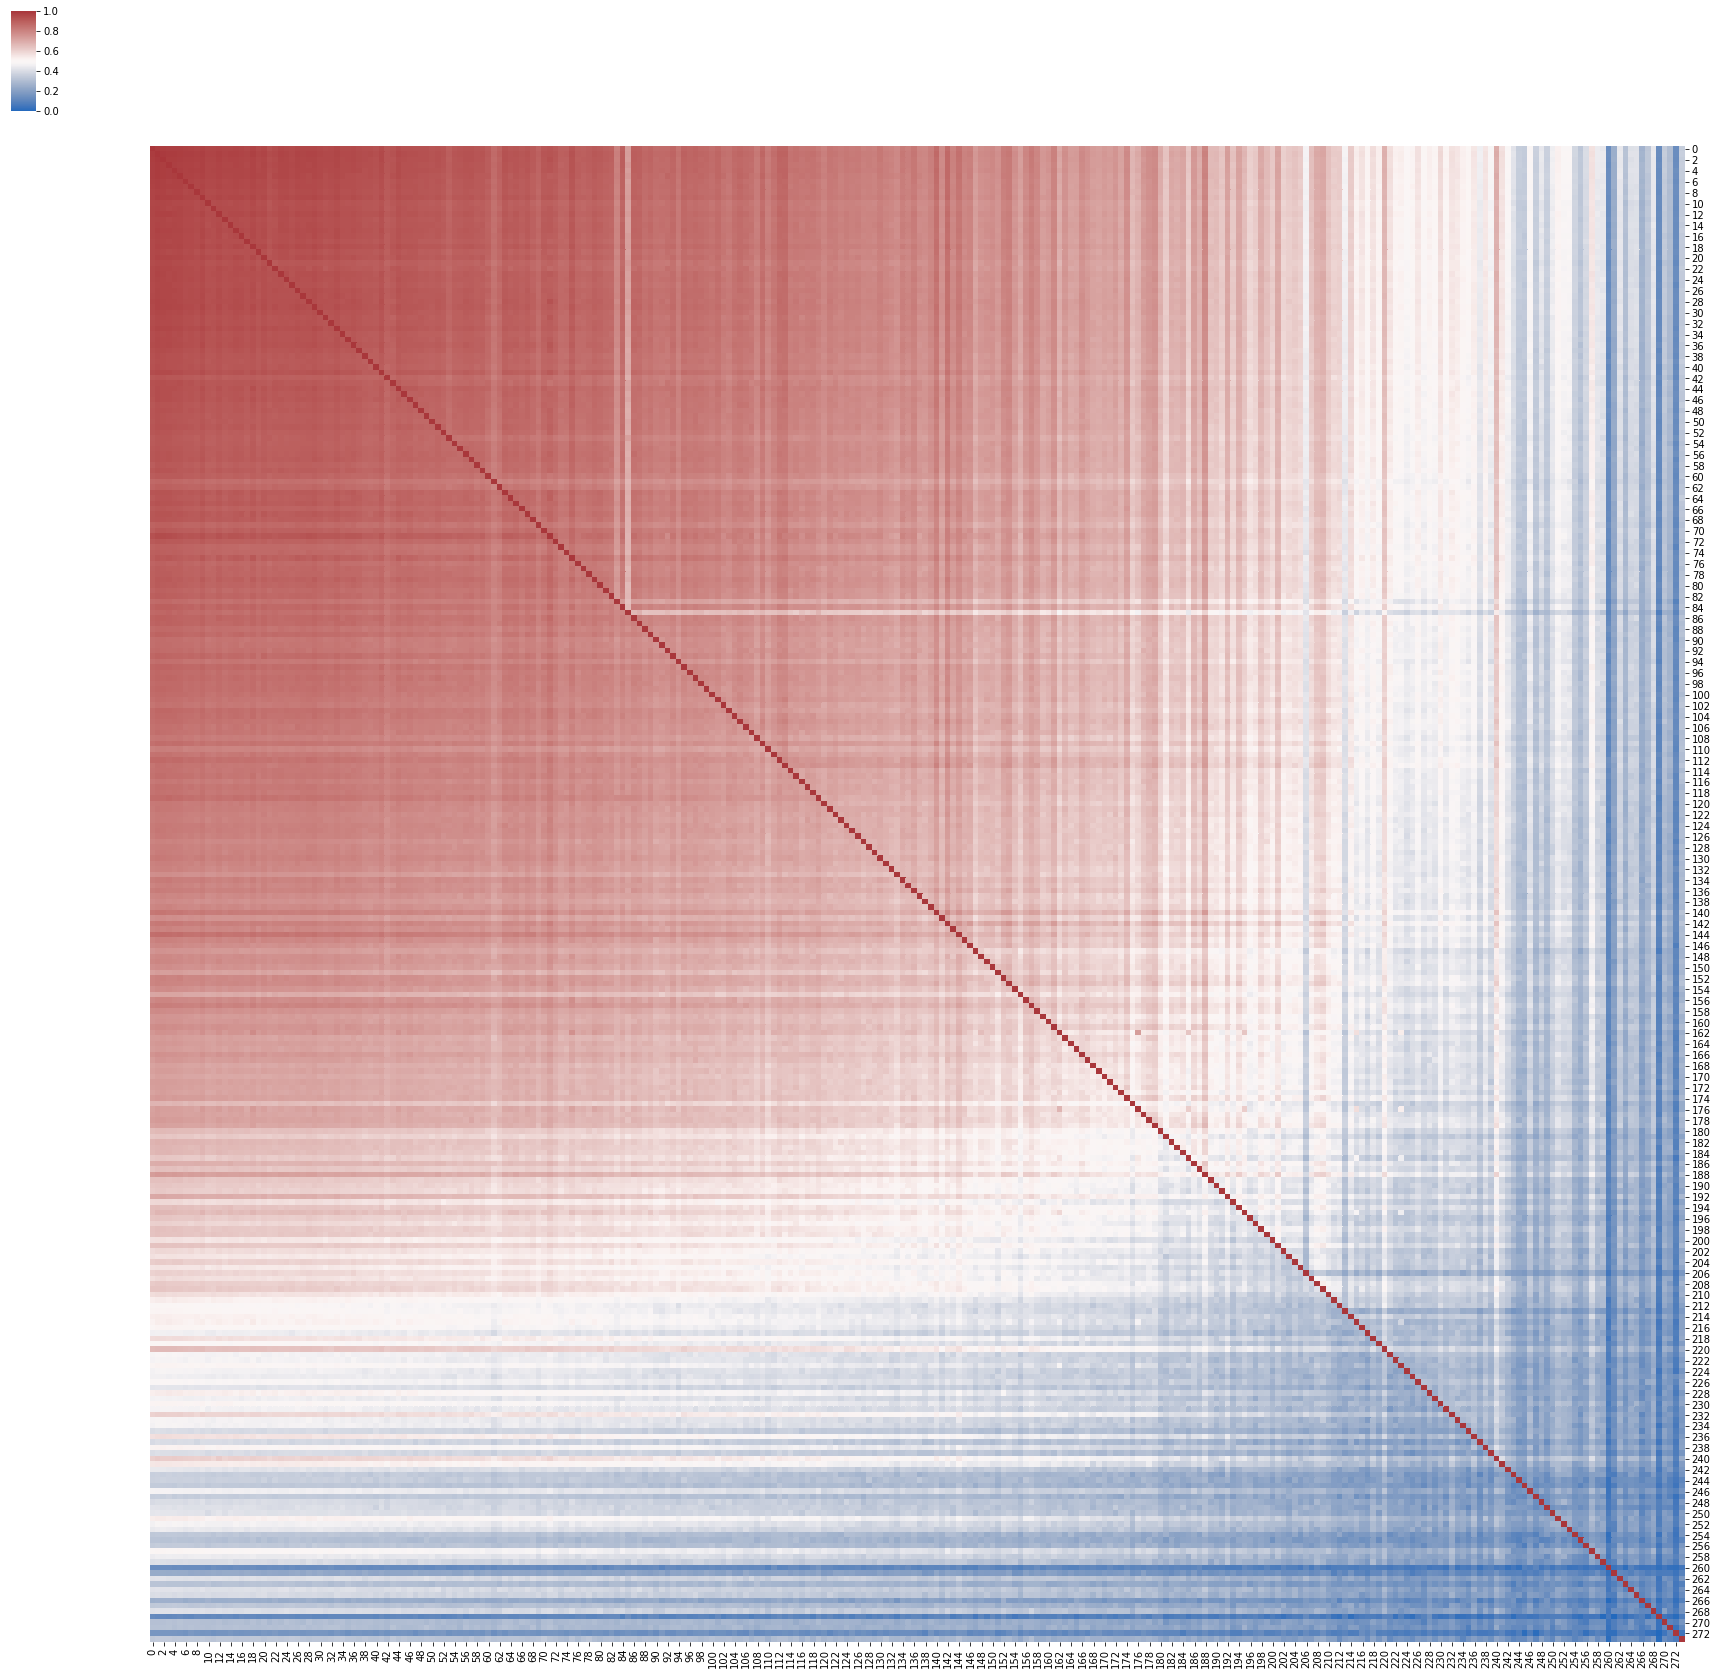

In [140]:
sns.clustermap(pd.DataFrame(plot_corr_mat),cmap="vlag",row_cluster=False,col_cluster=False,figsize=(30,30))
plt.show()

In [176]:
train_x = batch_dict[1]
batch_name = 'high-liver-alb'

# 1001 cellline
# matters_candidate = [50.73, 51.01, 51.02, 51.98, 51.99, 52.96, 52.98, 53.04, 54.01, 54.04, 56.02, 56.06, 57.02, 57.04, 60.0, 64.97, 64.99, 65.96, 66.97, 68.05, 69.04, 70.01, 70.97, 70.98, 71.93, 72.97, 73.05, 79.42, 81.04, 81.95, 81.99, 82.03, 82.97, 84.05, 85.04, 86.0, 87.06, 88.02, 88.97, 90.01, 91.03, 92.02, 93.01, 93.04, 93.99, 94.03, 95.03, 95.96, 96.01, 96.05, 96.93, 97.93, 97.97, 101.03, 104.01, 105.03, 105.97, 106.03, 106.99, 107.03, 108.02, 109.01, 109.04, 109.98, 110.03, 110.98, 111.03, 111.96, 112.96, 113.04, 113.97, 114.93, 115.0, 117.02, 118.03, 120.02, 121.04, 122.03, 123.02, 123.99, 124.04, 124.97, 125.04, 126.04, 126.97, 127.06, 127.95, 128.05, 128.96, 129.11, 130.95, 131.03, 132.03, 133.01, 134.05, 135.03, 136.01, 136.28, 142.07, 143.04, 143.95, 144.04, 145.04, 146.04, 146.95, 147.02, 148.03, 149.04, 149.88, 150.05, 150.89, 150.98, 151.05, 151.89, 151.95, 153.02, 153.96, 154.06, 154.95, 156.94, 157.04, 157.93, 158.05, 159.04, 160.04, 161.04, 162.04, 163.02, 164.04, 165.03, 165.91, 166.92, 167.94, 168.06, 168.94, 169.95, 170.08, 170.94, 171.96, 172.03, 172.96, 173.05, 174.04, 176.04, 178.03, 180.05, 182.06, 183.92, 184.94, 185.06, 185.93, 186.05, 186.93, 187.97, 188.05, 189.05, 190.04, 191.05, 192.05, 193.04, 194.06, 201.06, 201.91, 202.06, 202.91, 203.91, 204.05, 204.91, 205.05, 205.92, 206.05, 206.92, 207.04, 208.08, 208.92, 209.09, 209.93, 210.07, 210.93, 212.95, 213.9, 214.04, 216.05, 218.06, 221.06, 222.06, 223.89, 224.92, 225.91, 226.93, 228.89, 229.91, 230.86, 232.06, 232.88, 233.05, 233.87, 242.89, 243.9, 244.87, 245.88, 246.88, 247.88, 248.9, 249.9, 253.22, 254.86, 255.23, 256.24, 261.86, 262.87, 263.87, 264.89, 265.88, 266.88, 268.86, 269.88, 271.88, 281.26, 282.25, 282.86, 283.27, 284.85, 285.87, 287.87, 290.87, 291.85, 292.86, 293.85, 301.84, 302.85, 303.86, 304.86, 306.85, 308.84, 309.88, 314.84, 321.85, 322.84, 323.84, 324.84, 325.84, 333.83, 341.83, 342.83, 344.83, 346.83, 348.83, 350.82, 362.81, 363.82, 364.82, 365.82, 367.58, 380.8, 381.8, 382.8, 384.82, 386.8, 387.81, 402.79, 403.79, 404.79, 412.77, 424.78, 426.78, 433.76, 434.74, 440.76, 450.74, 455.75, 456.75, 464.75, 494.71]
# 20180713/liver-cancer-1
# matters_candidate = [51.01, 51.02, 51.99, 52.96, 53.04, 54.01, 54.04, 56.02, 56.06, 57.02, 57.04, 60.0, 64.97, 64.99, 65.96, 66.97, 68.05, 69.04, 70.01, 70.97, 70.98, 71.93, 72.97, 73.04, 79.43, 81.04, 81.95, 81.99, 82.03, 82.97, 84.05, 85.04, 86.0, 87.06, 88.02, 88.97, 90.01, 91.03, 92.02, 93.01, 93.04, 93.99, 94.03, 95.03, 95.96, 96.01, 96.05, 96.92, 97.93, 97.97, 101.03, 104.01, 105.03, 105.97, 106.03, 106.99, 107.03, 108.02, 109.01, 109.04, 109.98, 110.03, 110.98, 111.02, 111.96, 112.96, 113.04, 113.96, 114.93, 114.99, 117.02, 118.03, 120.02, 121.04, 122.03, 123.02, 123.99, 124.04, 124.97, 125.04, 126.05, 126.96, 127.07, 127.95, 128.05, 128.96, 129.11, 130.95, 131.03, 132.03, 133.01, 134.05, 135.04, 136.01, 136.29, 142.07, 143.04, 143.95, 144.04, 145.04, 146.04, 146.94, 147.02, 148.04, 149.04, 149.88, 150.05, 150.89, 150.98, 151.05, 151.89, 151.95, 153.02, 153.96, 154.07, 154.94, 156.94, 157.04, 157.92, 158.05, 159.04, 160.04, 161.04, 162.04, 163.02, 164.04, 165.03, 165.92, 166.92, 167.94, 168.06, 168.94, 169.95, 170.09, 170.94, 171.96, 172.03, 172.96, 173.05, 174.05, 176.05, 178.04, 180.05, 182.07, 183.93, 184.94, 185.06, 185.92, 186.06, 186.92, 187.97, 188.06, 189.05, 190.05, 191.05, 192.06, 193.04, 194.06, 201.06, 202.06, 202.91, 203.91, 204.05, 204.91, 205.06, 205.92, 206.06, 206.92, 207.05, 208.08, 208.93, 209.1, 209.94, 210.08, 210.94, 212.95, 213.9, 214.05, 216.06, 218.07, 221.07, 222.07, 223.89, 224.93, 225.92, 226.94, 228.9, 229.91, 230.86, 232.07, 232.87, 233.06, 233.87, 242.89, 243.9, 244.88, 245.89, 246.89, 247.89, 248.9, 249.91, 251.2, 253.22, 254.86, 255.24, 256.23, 261.87, 262.88, 263.88, 264.88, 265.88, 266.88, 268.88, 269.24, 269.89, 271.89, 277.22, 279.23, 281.25, 282.25, 282.87, 283.26, 284.87, 285.87, 287.88, 290.87, 291.86, 292.85, 293.85, 301.85, 302.86, 303.87, 304.86, 306.86, 308.85, 309.89, 314.84, 321.85, 322.85, 323.85, 324.85, 325.85, 333.83, 341.83, 342.84, 344.84, 346.85, 348.85, 350.83, 362.83, 363.83, 364.83, 365.83, 367.58, 380.81, 381.81, 382.81, 384.83, 386.83, 387.82, 402.8, 403.81, 404.81, 412.77, 424.81, 426.8, 433.77, 434.75, 440.77, 450.75, 456.75, 464.77, 504.78, 514.73, 520.74, 526.73, 542.74, 566.74, 576.68, 588.74, 668.67, 794.58, 795.59, 861.59, 883.72, 885.61]
# 20180919/y7
# matters_candidate = [51.01, 51.02, 51.99, 52.96, 53.04, 54.01, 54.04, 56.02, 56.05, 57.03, 57.04, 60.0, 64.97, 64.99, 65.96, 66.97, 68.05, 69.04, 70.01, 70.97, 70.98, 71.93, 72.97, 73.04, 79.42, 81.04, 81.95, 81.99, 82.03, 82.97, 84.05, 85.04, 86.0, 87.06, 88.02, 88.97, 90.01, 91.03, 92.02, 93.02, 93.04, 93.99, 94.03, 95.03, 95.96, 96.01, 96.05, 96.93, 97.93, 97.97, 101.03, 104.01, 105.03, 105.97, 106.03, 106.99, 107.04, 108.02, 109.01, 109.04, 109.98, 110.03, 110.98, 111.03, 111.96, 112.96, 113.04, 113.97, 114.93, 115.0, 117.03, 118.03, 120.02, 121.04, 122.03, 123.02, 124.0, 124.03, 124.97, 125.04, 126.04, 126.96, 127.06, 127.95, 128.05, 128.96, 129.11, 130.95, 131.03, 132.03, 133.01, 134.05, 135.04, 136.01, 136.28, 142.07, 143.05, 143.95, 144.04, 145.03, 146.04, 146.95, 147.02, 148.04, 149.04, 149.88, 150.05, 150.89, 150.99, 151.05, 151.89, 151.95, 153.02, 153.96, 154.07, 154.95, 156.94, 157.04, 157.93, 158.05, 159.04, 160.04, 161.05, 162.04, 163.02, 164.04, 165.03, 165.91, 166.92, 167.94, 168.06, 168.94, 169.95, 170.08, 170.94, 171.96, 172.03, 172.96, 173.05, 174.05, 176.05, 178.03, 180.05, 182.07, 183.92, 184.94, 185.06, 185.93, 186.06, 186.93, 187.97, 188.05, 189.05, 190.04, 191.05, 192.06, 193.05, 194.06, 201.06, 202.06, 202.91, 203.91, 204.05, 204.91, 205.05, 205.92, 206.05, 206.92, 207.05, 208.08, 208.92, 209.09, 209.93, 210.08, 210.93, 212.95, 213.9, 214.05, 216.05, 218.06, 221.06, 222.07, 223.89, 224.93, 225.92, 226.94, 228.89, 229.91, 230.86, 232.07, 232.88, 233.06, 233.88, 242.9, 243.91, 244.87, 245.88, 246.89, 247.89, 248.9, 249.9, 251.19, 253.22, 254.87, 255.23, 256.23, 261.86, 262.88, 263.88, 264.89, 265.88, 266.89, 268.87, 269.24, 269.89, 271.89, 277.21, 279.23, 281.25, 282.25, 282.87, 283.26, 284.86, 285.87, 287.88, 290.87, 291.86, 292.85, 293.85, 301.85, 302.86, 303.86, 304.86, 306.87, 308.85, 309.89, 314.85, 321.85, 322.85, 323.85, 324.85, 325.85, 333.83, 341.83, 342.85, 344.84, 346.85, 348.84, 350.83, 362.83, 363.83, 364.83, 365.83, 367.58, 380.81, 381.81, 382.81, 384.83, 386.82, 387.82, 402.8, 403.81, 404.81, 412.78, 424.8, 426.8, 433.78, 434.76, 440.78, 450.75, 456.76, 464.77, 504.77, 514.74, 520.75, 526.72, 542.74, 566.74, 576.69, 588.72, 668.67, 794.57, 795.59, 861.55, 883.59, 885.58]
# 20181103/lung-erxing
# matters_candidate = [51.01, 51.02, 51.98, 51.99, 52.96, 52.99, 53.04, 54.01, 54.04, 56.02, 56.06, 57.04, 66.97, 68.05, 70.98, 73.05, 81.05, 81.99, 82.03, 82.97, 85.04, 87.06, 88.02, 88.97, 90.01, 92.02, 93.04, 94.03, 95.03, 95.96, 96.01, 96.05, 97.97, 101.03, 104.01, 105.03, 105.97, 106.03, 106.99, 107.03, 108.03, 109.04, 109.98, 110.03, 111.03, 111.96, 112.96, 113.04, 113.97, 117.02, 121.04, 122.03, 124.04, 125.04, 126.05, 126.96, 127.06, 127.95, 128.05, 128.96, 129.11, 130.95, 131.03, 132.03, 134.05, 142.07, 143.05, 143.95, 144.04, 145.04, 146.04, 146.94, 147.02, 148.04, 149.04, 150.05, 151.05, 151.95, 154.07, 154.94, 156.93, 157.92, 158.05, 160.04, 161.04, 162.05, 163.02, 164.04, 165.03, 165.92, 166.92, 167.94, 168.08, 170.09, 170.94, 172.07, 172.96, 173.06, 174.05, 176.04, 183.93, 184.95, 185.06, 185.92, 186.06, 186.92, 187.97, 188.06, 189.06, 190.05, 191.05, 192.06, 193.05, 194.06, 201.06, 201.9, 202.06, 202.91, 203.9, 204.05, 204.9, 205.06, 205.91, 206.06, 206.92, 207.05, 208.08, 209.09, 209.94, 210.09, 212.96, 213.9, 214.05, 216.05, 218.07, 221.06, 222.07, 223.89, 224.93, 225.92, 226.94, 228.9, 229.91, 232.07, 232.9, 233.06, 233.86, 242.89, 243.9, 244.88, 245.89, 246.89, 247.88, 248.9, 249.9, 253.22, 254.86, 255.23, 256.23, 261.86, 262.88, 263.87, 264.88, 265.87, 266.87, 268.87, 269.89, 271.87, 281.25, 282.25, 282.86, 283.26, 284.87, 285.87, 287.87, 290.83, 291.84, 292.84, 293.84, 301.84, 302.85, 303.86, 304.85, 306.86, 308.84, 309.88, 314.83, 321.84, 322.85, 323.85, 324.84, 325.16, 325.84, 333.81, 341.82, 342.83, 344.83, 346.84, 348.84, 350.8, 362.82, 363.83, 364.83, 365.83, 367.58, 380.8, 381.8, 382.81, 384.83, 386.82, 387.81, 402.8, 403.81, 404.81, 412.77, 424.8, 426.8, 433.76, 434.75, 440.77, 450.74, 455.75, 456.74, 464.76, 494.71]
# matters_candidate = matters_candidate[:274]
# 20181106/mcf7-highres
# matters_candidate = [50.37, 51.38, 52.39, 53.39, 54.42, 55.4, 56.41, 57.4, 58.41, 63.39, 64.43, 65.44, 66.44, 67.46, 68.46, 69.46, 70.49, 71.48, 72.47, 73.49, 74.47, 75.47, 79.44, 80.46, 81.48, 82.51, 83.53, 84.53, 85.55, 86.51, 87.52, 88.53, 89.53, 90.54, 91.53, 92.56, 93.57, 94.56, 95.56, 96.56, 97.55, 98.59, 99.58, 102.55, 103.55, 104.59, 105.59, 106.6, 107.59, 108.63, 109.63, 110.63, 111.64, 112.59, 113.67, 114.65, 115.65, 116.59, 117.63, 119.63, 121.65, 122.66, 123.67, 124.69, 125.71, 126.68, 127.7, 128.63, 129.68, 130.69, 131.71, 133.71, 134.74, 135.71, 139.73, 140.74, 141.77, 142.73, 143.7, 144.68, 145.72, 146.72, 147.75, 148.75, 149.74, 150.79, 151.78, 152.78, 153.81, 154.81, 155.82, 156.81, 157.8, 158.77, 160.76, 161.77, 162.78, 163.81, 164.79, 165.74, 166.81, 167.82, 168.83, 169.87, 170.86, 171.84, 172.85, 173.85, 174.85, 175.82, 180.79, 181.77, 182.81, 183.81, 184.87, 185.88, 186.89, 187.89, 188.91, 189.91, 190.92, 191.85, 194.91, 195.86, 198.83, 199.84, 200.87, 201.89, 202.93, 203.95, 204.92, 205.92, 206.95, 207.92, 208.92, 209.97, 210.99, 211.98, 212.97, 213.97, 216.94, 217.95, 221.92, 223.94, 224.95, 225.99, 227.02, 228.05, 229.99, 231.01, 233.0, 234.02, 237.96, 239.97, 242.03, 243.98, 245.94, 256.34, 258.0, 261.97, 264.02, 268.05, 278.02, 280.06, 282.42, 284.04, 300.22, 302.08, 308.09, 318.09, 320.12, 324.14, 330.11, 340.15, 342.17, 346.18, 348.21, 364.23, 380.25, 386.27, 388.3, 404.33, 410.3, 420.35, 426.36, 442.38, 444.41, 448.37, 450.43, 466.48, 488.52]
# 20181109/liver-highres-all
# matters_candidate = [50.14, 51.11, 52.11, 53.11, 54.13, 55.12, 56.13, 57.12, 58.12, 59.13, 60.09, 61.1, 62.11, 63.1, 64.14, 65.15, 66.15, 67.17, 68.17, 69.16, 70.19, 71.18, 72.18, 73.19, 74.18, 75.17, 76.15, 77.16, 78.17, 79.15, 80.17, 81.19, 82.23, 83.24, 84.24, 85.25, 86.23, 87.24, 88.24, 89.25, 90.24, 91.24, 92.27, 93.28, 94.28, 95.27, 96.27, 97.26, 98.3, 99.31, 100.29, 101.32, 102.26, 103.27, 104.3, 105.3, 106.32, 107.32, 108.35, 109.35, 110.35, 111.36, 112.32, 113.39, 114.38, 115.38, 116.34, 117.35, 118.36, 119.36, 120.36, 121.37, 122.39, 123.4, 124.42, 125.44, 126.41, 127.44, 128.36, 129.45, 130.45, 131.44, 132.44, 133.45, 134.47, 135.45, 136.4, 137.41, 138.46, 139.47, 140.49, 141.5, 142.48, 143.47, 144.44, 145.48, 146.48, 147.5, 148.51, 149.49, 150.54, 151.54, 152.55, 153.58, 154.57, 155.59, 156.58, 157.55, 158.53, 159.5, 160.54, 161.55, 162.55, 163.57, 164.56, 165.51, 166.6, 167.62, 168.62, 169.66, 170.65, 171.63, 172.63, 173.63, 174.63, 175.62, 176.58, 177.59, 178.58, 179.57, 181.56, 182.66, 183.63, 184.7, 185.68, 186.68, 187.68, 188.7, 189.71, 190.71, 191.71, 192.67, 193.7, 194.72, 195.7, 196.66, 197.65, 199.66, 201.72, 202.72, 203.75, 204.74, 205.75, 206.78, 207.78, 208.79, 209.83, 211.83, 213.81, 215.74, 217.79, 219.74, 221.87, 225.88, 227.93, 231.88, 233.91, 237.91, 239.82, 241.91, 243.91, 245.87, 250.01, 254.15, 256.2, 259.92, 261.93, 264.22, 268.09, 270.23, 275.97, 278.23, 280.31, 282.34, 284.41, 294.38, 296.21, 298.1, 300.15, 302.1, 304.4, 306.42, 308.3, 310.47, 314.19, 318.14, 320.16, 324.2, 328.55, 336.24, 340.22, 342.26, 344.3, 346.27, 356.3, 358.33, 362.34, 364.37, 380.4, 384.79, 386.47, 396.46, 404.55, 410.6, 420.57, 426.64, 436.66, 448.75, 488.93, 529.12, 547.61, 551.21, 591.36]
# 20181111/liver-hoechst-blood
# matters_candidate = [50.14, 51.1, 52.1, 53.1, 54.13, 55.12, 56.13, 57.11, 58.12, 59.12, 63.09, 64.13, 65.14, 66.14, 67.17, 68.17, 69.16, 70.19, 71.18, 72.18, 73.2, 74.17, 75.16, 79.14, 80.17, 81.19, 82.22, 83.23, 84.24, 85.25, 86.22, 87.24, 88.24, 89.23, 90.24, 91.23, 92.26, 93.27, 94.27, 95.27, 96.28, 97.25, 98.3, 99.3, 101.3, 103.26, 104.29, 105.29, 106.31, 107.31, 108.34, 109.35, 110.35, 111.36, 112.33, 113.39, 114.37, 115.37, 121.36, 122.38, 123.39, 124.41, 125.43, 126.41, 127.45, 128.37, 129.46, 130.44, 131.42, 133.43, 134.46, 135.45, 139.47, 140.48, 141.5, 142.48, 143.45, 144.44, 145.48, 146.47, 147.49, 148.49, 149.49, 150.53, 151.54, 152.54, 153.57, 154.57, 155.59, 156.58, 157.54, 158.52, 159.47, 161.53, 162.54, 163.55, 164.56, 165.51, 166.61, 167.62, 168.62, 169.65, 170.65, 171.62, 172.63, 173.62, 174.62, 175.61, 181.54, 182.67, 183.63, 184.7, 185.67, 186.67, 187.67, 188.69, 189.71, 190.71, 191.7, 194.71, 195.69, 199.64, 201.71, 202.71, 203.74, 204.74, 205.74, 206.78, 207.78, 208.79, 209.83, 211.83, 213.81, 215.72, 217.77, 221.83, 225.88, 227.93, 231.86, 233.9, 241.9, 243.9, 245.87, 250.01, 261.91, 264.21, 268.09, 270.23, 280.27, 282.31, 284.39, 294.36, 298.09, 300.11, 302.07, 304.4, 306.42, 308.32, 310.48, 314.17, 318.11, 324.18, 328.56, 340.21, 342.23, 344.27, 358.29, 362.31, 364.34, 384.78, 386.43, 404.51, 410.56, 426.58, 436.66, 448.72, 488.91, 529.11, 547.58, 551.18, 591.34]
# 20181111/liver-free
# matters_candidate = [50.13, 51.09, 52.09, 53.08, 54.11, 55.1, 56.11, 57.09, 58.1, 59.1, 63.07, 64.11, 65.12, 66.12, 67.14, 68.14, 69.13, 70.16, 71.15, 72.15, 73.16, 74.15, 75.14, 79.12, 80.14, 81.16, 82.19, 83.2, 84.2, 85.21, 86.19, 87.2, 88.21, 89.21, 90.21, 91.2, 92.23, 93.24, 94.24, 95.23, 96.23, 97.22, 98.26, 99.26, 101.27, 103.23, 104.26, 105.26, 106.27, 107.27, 108.3, 109.31, 110.3, 111.31, 112.28, 113.34, 114.34, 115.33, 121.32, 122.34, 123.34, 124.37, 125.38, 126.36, 127.39, 128.31, 129.4, 130.39, 131.38, 133.39, 134.42, 135.4, 139.41, 140.44, 141.45, 142.42, 143.41, 144.38, 145.43, 146.42, 147.44, 148.46, 149.43, 150.48, 151.48, 152.49, 153.51, 154.53, 155.53, 156.53, 157.49, 158.48, 159.43, 161.49, 162.49, 163.5, 164.53, 165.44, 166.55, 167.56, 168.57, 169.6, 170.6, 171.57, 172.58, 173.57, 174.58, 175.57, 181.48, 182.64, 183.56, 184.66, 185.63, 186.63, 187.63, 188.65, 189.66, 190.67, 191.67, 194.68, 195.66, 199.58, 201.67, 202.68, 203.7, 204.72, 205.69, 206.75, 207.74, 208.75, 209.79, 211.8, 213.77, 215.67, 217.74, 221.79, 225.83, 227.89, 231.84, 233.87, 241.85, 243.84, 245.82, 249.97, 261.85, 264.17, 268.05, 270.19, 280.21, 282.24, 284.36, 294.35, 298.05, 300.08, 302.03, 304.34, 306.37, 308.2, 310.43, 314.15, 318.07, 324.1, 328.51, 340.16, 342.21, 344.25, 358.28, 362.3, 364.3, 384.7, 386.37, 404.47, 410.54, 426.52, 436.62, 448.68, 488.84, 529.02, 547.55, 551.1, 591.25];
# 20181119/liver
# matters_candidate = [50.14, 51.11, 52.11, 53.11, 54.13, 55.12, 56.13, 57.12, 58.12, 59.13, 63.1, 64.14, 65.15, 66.15, 67.17, 68.17, 69.16, 70.19, 71.18, 72.19, 73.19, 74.18, 75.17, 79.15, 80.17, 81.2, 82.23, 83.24, 84.24, 85.25, 86.23, 87.24, 88.25, 89.25, 90.25, 91.24, 92.27, 93.28, 94.28, 95.28, 96.28, 97.27, 98.31, 99.31, 101.32, 103.27, 104.3, 105.31, 106.32, 107.32, 108.35, 109.35, 110.35, 111.37, 112.33, 113.4, 114.39, 115.39, 121.37, 122.4, 123.4, 124.42, 125.44, 126.41, 127.45, 128.37, 129.46, 130.45, 131.44, 133.45, 134.48, 135.46, 139.48, 140.49, 141.51, 142.48, 143.47, 144.44, 145.49, 146.49, 147.51, 148.51, 149.5, 150.55, 151.55, 152.55, 153.58, 154.58, 155.6, 156.58, 157.55, 158.53, 159.5, 161.55, 162.56, 163.57, 164.56, 165.52, 166.61, 167.62, 168.63, 169.66, 170.65, 171.63, 172.64, 173.64, 174.64, 175.62, 181.57, 182.67, 183.64, 184.7, 185.68, 186.68, 187.69, 188.7, 189.72, 190.72, 191.71, 194.72, 195.7, 199.67, 201.72, 202.73, 203.76, 204.74, 205.76, 206.78, 207.78, 208.8, 209.83, 211.84, 213.82, 215.75, 217.79, 221.88, 225.88, 227.94, 231.88, 233.91, 241.92, 243.92, 245.88, 250.01, 261.94, 264.23, 268.1, 270.24, 280.32, 282.35, 284.42, 294.38, 298.11, 300.16, 302.11, 304.42, 306.43, 308.31, 310.47, 314.2, 318.15, 324.21, 328.57, 340.23, 342.26, 344.3, 358.33, 362.34, 364.38, 384.8, 386.48, 404.56, 410.61, 426.67, 436.68, 448.77, 488.95, 529.14, 547.63, 551.22, 591.38]
# 20181119/lung
# matters_candidate = [50.15, 51.11, 52.11, 53.11, 54.13, 55.12, 56.13, 57.12, 58.13, 59.13, 63.1, 64.14, 65.15, 66.15, 67.18, 68.18, 69.17, 70.2, 71.19, 72.19, 73.2, 74.18, 75.18, 79.15, 80.17, 81.2, 82.23, 83.25, 84.24, 85.26, 86.23, 87.25, 88.25, 89.25, 90.25, 91.24, 92.27, 93.29, 94.28, 95.28, 96.28, 97.27, 98.31, 99.32, 101.31, 103.28, 104.31, 105.31, 106.33, 107.32, 108.36, 109.36, 110.36, 111.37, 112.33, 113.41, 114.39, 115.39, 121.37, 122.4, 123.41, 124.43, 125.45, 126.42, 127.45, 128.38, 129.46, 130.45, 131.45, 133.46, 134.48, 135.46, 139.48, 140.5, 141.52, 142.48, 143.47, 144.45, 145.49, 146.49, 147.51, 148.52, 149.5, 150.55, 151.55, 152.56, 153.59, 154.58, 155.6, 156.59, 157.55, 158.53, 159.51, 161.55, 162.56, 163.58, 164.57, 165.53, 166.61, 167.63, 168.63, 169.67, 170.66, 171.64, 172.64, 173.64, 174.64, 175.62, 181.58, 182.67, 183.64, 184.71, 185.68, 186.68, 187.69, 188.7, 189.72, 190.72, 191.71, 194.72, 195.7, 199.67, 201.72, 202.73, 203.76, 204.75, 205.76, 206.79, 207.79, 208.81, 209.84, 211.84, 213.82, 215.75, 217.8, 221.85, 225.89, 227.94, 231.89, 233.92, 241.92, 243.91, 245.88, 250.01, 261.93, 264.22, 268.1, 270.24, 280.31, 282.36, 284.43, 294.39, 298.11, 300.16, 302.11, 304.42, 306.44, 308.3, 310.48, 314.18, 318.15, 324.21, 328.55, 340.24, 342.27, 344.3, 358.32, 362.33, 364.39, 384.77, 386.53, 404.57, 410.62, 426.68, 436.67, 448.79, 488.97, 529.13, 547.59, 551.23, 591.38]
# 20181126/lung-calara
# matters_candidate = [50.13, 51.08, 52.08, 53.08, 54.11, 55.09, 56.09, 57.08, 58.09, 63.06, 64.11, 65.11, 66.11, 67.13, 68.13, 69.13, 70.15, 71.15, 72.14, 73.16, 74.13, 75.13, 79.1, 80.12, 81.14, 82.17, 83.19, 84.17, 85.2, 86.16, 87.19, 88.18, 89.18, 90.18, 91.17, 92.19, 93.21, 94.21, 95.21, 96.22, 97.2, 98.23, 99.23, 101.21, 104.22, 105.23, 106.24, 107.23, 108.26, 109.26, 110.27, 111.28, 112.23, 113.31, 114.28, 115.25, 121.26, 122.28, 123.3, 124.3, 125.33, 126.29, 127.34, 128.26, 129.33, 130.32, 131.3, 133.3, 134.34, 135.32, 139.34, 140.34, 141.37, 142.35, 143.33, 144.31, 145.33, 146.35, 147.36, 148.36, 149.35, 150.37, 151.39, 152.4, 153.44, 154.43, 155.46, 156.44, 157.4, 158.41, 159.33, 161.38, 162.39, 163.36, 164.42, 165.4, 166.43, 167.46, 168.48, 169.48, 170.51, 171.42, 172.47, 173.46, 174.43, 175.46, 181.4, 182.44, 183.49, 184.54, 185.49, 186.5, 187.46, 188.54, 189.55, 190.51, 191.5, 194.5, 195.51, 199.45, 201.52, 202.55, 203.51, 204.54, 205.55, 206.58, 207.6, 208.54, 209.63, 211.58, 213.59, 215.53, 217.5, 225.55, 227.6, 231.55, 233.6, 241.59, 257.59, 261.6, 275.63, 277.71, 281.97, 283.95, 301.8, 317.77, 323.84, 340.17, 386.06, 426.16];
# 20181126/lung-type2
# matters_candidate = [50.14, 51.1, 52.1, 53.1, 54.13, 55.12, 56.12, 57.11, 58.12, 63.09, 64.13, 65.14, 66.15, 67.17, 68.17, 69.16, 70.19, 71.18, 72.18, 73.19, 74.17, 75.17, 79.14, 80.17, 81.19, 82.22, 83.23, 84.23, 85.25, 86.21, 87.24, 88.23, 89.24, 90.24, 91.23, 92.25, 93.28, 94.27, 95.27, 96.28, 97.26, 98.3, 99.29, 104.29, 105.3, 106.31, 107.29, 108.34, 109.34, 110.35, 111.36, 112.32, 113.39, 114.37, 115.36, 122.38, 123.39, 124.41, 125.43, 126.39, 127.44, 128.35, 129.44, 130.43, 131.42, 133.4, 134.44, 135.44, 139.45, 140.47, 141.49, 142.46, 143.45, 144.41, 145.47, 146.47, 147.48, 148.49, 149.49, 150.52, 151.54, 152.54, 153.57, 154.57, 155.58, 156.57, 157.54, 158.52, 159.45, 162.5, 164.55, 165.5, 166.59, 167.61, 168.61, 169.65, 170.64, 171.61, 172.63, 173.62, 174.62, 175.6, 181.53, 182.66, 183.62, 184.7, 185.67, 186.66, 187.67, 188.69, 189.7, 190.7, 191.7, 194.71, 195.69, 202.72, 203.74, 204.74, 205.74, 206.78, 207.77, 208.79, 209.78, 211.82, 213.81, 215.67, 217.77, 225.87, 227.93, 231.88, 233.91, 243.89, 245.87, 250.0, 261.9, 264.21, 268.09, 270.22, 282.24, 284.25, 304.4, 306.42, 308.32, 310.47, 312.5, 318.12, 324.18, 328.55, 344.27, 364.34, 384.75, 386.46, 404.52, 410.6, 426.62, 448.75, 488.94, 529.13, 547.58, 551.18];
# 20181208/intestine
# matters_candidate = [50.35, 51.37, 52.38, 53.39, 54.42, 55.42, 56.44, 57.43, 58.45, 63.46, 64.51, 65.53, 66.54, 67.57, 68.58, 69.58, 70.61, 71.61, 72.62, 73.64, 74.63, 75.63, 79.64, 80.67, 81.7, 82.75, 83.77, 84.77, 85.79, 86.76, 87.79, 88.81, 89.82, 90.83, 91.83, 92.87, 93.89, 94.9, 95.9, 96.9, 97.9, 98.95, 99.97, 101.97, 102.94, 103.96, 105.0, 106.01, 107.04, 108.04, 109.08, 110.09, 111.1, 112.12, 113.08, 114.17, 115.16, 116.17, 122.21, 123.24, 124.25, 125.29, 126.31, 127.28, 128.33, 129.27, 130.35, 131.35, 132.37, 134.39, 135.43, 136.41, 140.45, 141.49, 142.51, 143.49, 144.48, 145.48, 146.53, 147.54, 148.57, 149.58, 150.56, 151.63, 152.64, 153.65, 154.69, 155.7, 156.72, 157.72, 158.69, 159.68, 160.67, 162.73, 163.75, 164.77, 165.76, 166.73, 167.82, 168.84, 169.86, 170.91, 171.9, 172.89, 173.92, 174.92, 175.94, 176.92, 182.93, 185.0, 186.07, 187.07, 188.07, 189.09, 190.12, 191.15, 192.16, 193.14, 195.17, 196.2, 197.16, 201.19, 202.26, 203.25, 204.27, 205.29, 207.31, 208.36, 209.36, 210.39, 211.44, 212.45, 213.45, 214.46, 215.46, 217.4, 219.46, 223.5, 225.55, 227.61, 229.66, 235.74, 241.71, 243.8, 245.78, 247.79, 256.17, 258.25, 259.89, 264.0, 270.13, 280.23, 282.58, 284.62, 286.48, 304.54, 306.75, 310.64, 313.04, 320.73, 326.83, 332.92, 345.04, 347.09, 349.12, 365.33, 367.38, 369.39, 373.45, 387.66, 389.69, 407.95, 409.97, 414.02, 430.24, 446.41, 452.55, 471.27, 493.11, 515.41, 533.67, 555.98, 596.51, 637.04, 659.42];
# 20181208/intestine-1
# matters_candidate = [50.09, 51.0, 52.0, 53.0, 54.02, 55.0, 56.0, 56.99, 57.99, 58.99, 62.94, 63.98, 64.98, 65.98, 67.0, 67.99, 68.98, 70.01, 70.99, 71.98, 72.99, 73.97, 74.96, 78.92, 79.93, 80.95, 81.98, 82.99, 83.98, 84.99, 85.95, 86.96, 87.97, 88.96, 89.96, 90.95, 91.97, 92.98, 93.97, 94.96, 96.94, 97.97, 98.98, 99.94, 100.95, 101.91, 102.92, 103.94, 104.94, 105.95, 106.94, 107.97, 108.96, 109.96, 110.97, 111.91, 112.99, 113.97, 114.96, 120.92, 121.94, 122.93, 123.95, 124.97, 125.92, 126.96, 127.88, 128.95, 129.94, 130.94, 131.93, 132.93, 133.96, 134.93, 138.92, 139.93, 140.95, 141.9, 142.88, 143.86, 144.9, 145.9, 146.91, 147.92, 148.88, 149.93, 150.93, 151.92, 152.95, 153.94, 154.95, 155.94, 156.9, 157.88, 158.84, 160.88, 161.88, 162.89, 163.88, 164.82, 165.9, 166.91, 167.9, 168.95, 169.92, 170.9, 171.9, 172.9, 173.9, 174.88, 180.79, 181.9, 182.83, 183.89, 184.87, 185.86, 186.86, 187.88, 188.89, 189.89, 190.86, 192.86, 193.87, 194.85, 198.79, 199.84, 200.82, 201.83, 202.84, 203.84, 204.82, 205.86, 206.85, 207.86, 208.89, 209.9, 210.89, 211.87, 212.86, 214.78, 215.82, 220.77, 222.81, 223.81, 224.83, 226.86, 228.81, 229.82, 230.83, 232.84, 240.8, 242.75, 244.72, 245.78, 246.8, 248.83, 252.97, 255.03, 260.7, 266.74, 274.65, 276.69, 279.0, 281.01, 282.99, 294.68, 300.64, 302.78, 306.63, 309.01, 310.98, 312.63, 314.65, 316.57, 322.6, 324.74, 342.57, 344.55, 360.51, 362.52, 368.51, 382.5, 384.5, 386.5, 402.47, 404.48, 408.48, 424.44, 446.41, 464.89, 486.35, 504.3, 548.26, 588.18]
# 20181208/liver-alb
matters_candidate = [50.09, 51.0, 51.99, 52.99, 54.0, 54.99, 55.99, 56.98, 57.98, 58.98, 62.93, 63.97, 64.97, 65.97, 66.99, 67.98, 68.97, 69.99, 70.98, 71.97, 72.97, 73.96, 74.95, 78.91, 79.92, 80.94, 81.97, 82.97, 83.97, 84.98, 85.94, 86.96, 87.95, 88.96, 89.95, 90.94, 91.96, 92.96, 93.95, 94.95, 95.94, 96.93, 97.96, 98.95, 100.95, 103.92, 104.92, 105.94, 106.93, 107.95, 108.95, 109.94, 110.95, 111.91, 112.97, 113.95, 114.94, 120.9, 121.92, 122.92, 123.94, 124.95, 125.91, 126.95, 127.87, 128.94, 129.92, 130.91, 132.9, 133.94, 134.91, 138.9, 139.91, 140.93, 141.89, 142.89, 143.85, 144.88, 145.88, 146.89, 147.89, 148.88, 149.91, 150.91, 151.91, 152.93, 153.92, 154.93, 155.92, 156.88, 157.85, 160.86, 161.86, 162.86, 163.85, 164.81, 165.88, 166.9, 167.89, 168.93, 169.91, 170.88, 171.89, 172.88, 173.86, 174.83, 180.77, 181.86, 182.83, 183.89, 184.85, 185.83, 186.84, 187.85, 188.87, 189.86, 190.82, 192.81, 193.84, 194.79, 198.76, 200.79, 201.79, 202.81, 204.81, 205.83, 206.83, 207.84, 208.88, 209.89, 210.87, 211.86, 212.83, 214.74, 216.76, 220.83, 224.83, 226.87, 228.79, 230.78, 232.79, 240.77, 242.73, 244.71, 248.83, 252.96, 255.0, 260.7, 262.97, 264.95, 266.94, 268.97, 274.63, 276.93, 278.96, 280.98, 283.07, 288.8, 290.96, 292.97, 300.62, 302.94, 304.94, 306.93, 308.97, 311.03, 312.58, 314.66, 316.55, 322.57, 324.59, 326.95, 328.9, 330.93, 340.49, 342.53, 344.52, 356.49, 360.46, 362.49, 364.53, 368.47, 376.45, 382.81, 384.46, 396.42, 402.41, 404.43, 408.43, 416.38, 424.4, 446.37, 486.3];

data_134 = train_x[:,matters_candidate.index(133.94)]

In [177]:
cor_array = np.zeros(shape=(len(matters_candidate,)))
for i in range(len(matters_candidate)):
    [a,b] = pearsonr(data_134,train_x[:,i])
    cor_array[i] = a
sorted_idx = np.flip(np.argsort(cor_array),axis=0)
sorted_cors = np.flip(np.sort(cor_array),axis=0)
matters_candidate_np = np.array(matters_candidate)
print(matters_candidate_np[sorted_idx[:20]])
print(sorted_cors[:20])
sorted_matters = matters_candidate_np[sorted_idx[:20]]
sorted_corrs = sorted_cors
df[batch_name+'_matter'] = pd.Series(sorted_matters)
df[batch_name+'_corr'] = pd.Series(sorted_corrs)

[ 133.94   65.97   78.91  127.87   90.94   64.97   62.93   74.95  180.77
   63.97  143.85   89.95  106.93  111.91   79.92   96.93   80.94  105.94
   50.09   67.98]
[ 1.          0.86054177  0.85917023  0.85429423  0.8463044   0.84443778
  0.83869012  0.83861985  0.82941659  0.82921321  0.82675225  0.82617307
  0.82077966  0.815531    0.8133906   0.80581071  0.80181705  0.79800392
  0.78816908  0.78307441]


In [178]:
df

,10A_corr,10A_matter,A549_matter,A549_corr,Hela_matter,Hela_corr,SK_matter,SK_corr,liver-cancer-1_matter,liver-cancer-1_corr,...,high-lung-calara_matter,high-lung-calara_corr,high-lung-type2_matter,high-lung-type2_corr,high-intestine_matter,high-intestine_corr,high-intestine-1_matter,high-intestine-1_corr,high-liver-alb_matter,high-liver-alb_corr
0,1.000000,134.05,134.05,1.000000,134.05,1.000000,134.05,1.000000,134.05,1.000000,...,134.34,1.000000,134.44,1.000000,135.43,1.000000,133.96,1.000000,133.94,1.000000
1,0.911386,127.95,127.95,0.911940,127.95,0.959484,127.95,0.929144,127.95,0.916224,...,79.10,0.942994,128.35,0.940054,129.27,0.907621,127.88,0.881320,65.97,0.860542
2,0.907149,143.95,143.95,0.907181,143.95,0.952862,143.95,0.919668,143.95,0.901525,...,128.26,0.936784,79.14,0.939949,182.93,0.902906,180.79,0.876378,78.91,0.859170
3,0.889596,111.96,111.96,0.887124,111.96,0.945908,90.01,0.908175,90.01,0.890329,...,63.06,0.929984,144.41,0.929373,79.64,0.887006,78.92,0.871824,127.87,0.854294
4,0.874062,106.99,106.99,0.884924,106.99,0.945262,111.96,0.906565,111.96,0.885369,...,90.18,0.922856,97.26,0.927143,66.54,0.886858,62.94,0.863371,90.94,0.846304
5,0.862643,117.02,90.01,0.862539,90.01,0.940798,106.99,0.894598,117.02,0.876924,...,97.20,0.922262,90.24,0.925274,145.48,0.886830,65.98,0.856100,64.97,0.844438
6,0.856156,92.02,117.02,0.856114,117.02,0.923770,117.02,0.893381,92.02,0.853895,...,144.31,0.921287,63.09,0.922041,63.46,0.886540,143.86,0.855465,62.93,0.838690
7,0.840651,90.01,92.02,0.846514,92.02,0.922459,92.02,0.893079,132.03,0.837411,...,112.23,0.913030,165.50,0.911948,90.83,0.885876,89.96,0.851957,74.95,0.838620
8,0.835234,111.03,125.04,0.814807,111.03,0.909041,111.03,0.882904,106.03,0.831150,...,66.11,0.903351,112.32,0.905893,113.08,0.874554,111.91,0.841595,180.77,0.829417
9,0.829662,106.03,106.03,0.814260,106.03,0.903136,106.03,0.875579,131.03,0.809635,...,106.24,0.897818,106.31,0.899324,65.53,0.871824,64.98,0.840095,63.97,0.829213


In [179]:
# pd_dict={'10A_matter':matters_candidate_np[sorted_idx[:20]],
#         '10A_corr':sorted_cors[:20]}

# df = pd.DataFrame(pd_dict)
writer = pd.ExcelWriter('/home/yzy/20181214_process/top20_corr.xlsx')
df.to_excel(writer)
writer.save()

In [25]:
df['10A_test'] = pd.Series(sorted_matters)

In [26]:
df

,10A_corr,10A_matter,10A_test
0,1.000000,134.05,134.05
1,0.911386,127.95,127.95
2,0.907149,143.95,143.95
3,0.889596,111.96,111.96
4,0.874062,106.99,106.99
5,0.862643,117.02,117.02
6,0.856156,92.02,92.02
7,0.840651,90.01,90.01
8,0.835234,111.03,111.03
9,0.829662,106.03,106.03


In [3]:
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)


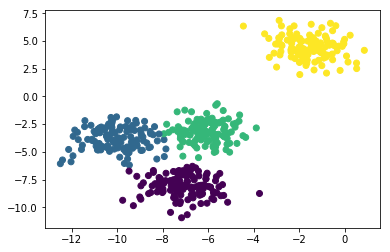

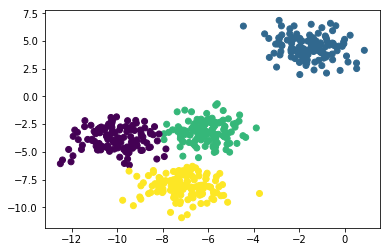

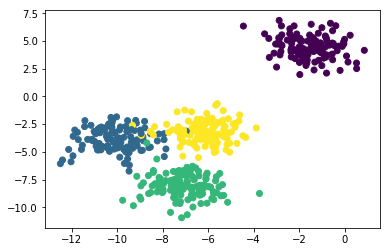

In [31]:
y_kmeans = KMeans(4).fit_predict(X)
plt.scatter(X[:,0],X[:,1],c=y_RMKKM)
plt.show()
plt.scatter(X[:,0],X[:,1],c=y_kmeans)
plt.show()
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [32]:
adjusted_rand_score(y_RMKKM,y)

0.94761771713501031

In [33]:
adjusted_rand_score(y_kmeans,y)

0.94263543180844356

In [7]:
kernel_list = [rbf_kernel(X,gamma=1),rbf_kernel(X,gamma=0.1)]
kernel_list = list(map(lambda m:numpy2mat(m),kernel_list))

In [15]:
gamma=0.5
rst = eng.RMKKM(kernel_list,4.0,'gamma', gamma, 'maxiter', 50, 'replicates', 1,nargout=3)

In [29]:
y_RMKKM=np.array(rst[0])[:,0]

In [24]:
np.sqrt(rst[1][0])+np.sqrt(rst[1][1])

array([ 1.])

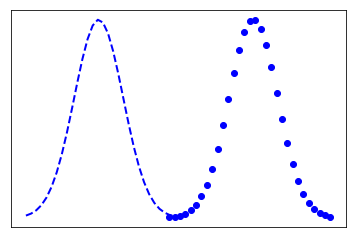

In [242]:
mu, sigma = 0, 0.1 # mean and standard deviation
mu2 = 0.63
s = np.random.normal(mu, sigma, 1000)
s2 = np.random.normal(mu2, sigma, 1000)
# count, bins, ignored = plt.hist(s, 30, density=True)
# count2, bins2, ignored2 = plt.hist(s2, 30, density=True)

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),'--',linewidth=2, color='b')
plt.plot(bins2, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins2 - mu2)**2 / (2 * sigma**2) ),'o',linewidth=2, color='b')

plt.xticks([])
plt.yticks([])
# plt.xlim((-0.5,1.))
# plt.axis('off')
plt.show()

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
from sklearn.preprocessing import *


In [80]:
import sklearn
sklearn.__version__

'0.19.1'

In [166]:
def get_img_mat(img_name,img_path='/home/yzy/SIMS/'):
    img_file = '{0}{1}'.format(img_path,img_name)
    line_count = 0
    line_li = []
    img_mat = []
    with open(img_file,'r') as f:
        for line in f:
            line_count+=1
            line_li.append(line)
            cur_line=line.split('\t')
            cur_line = list(map(int,cur_line))
            img_mat.append(cur_line)
    img_mat_np = np.array(img_mat)
#     img_mat_np = np.log(img_mat_np+1)
    return img_mat_np

def img_lab2rgb(img_np_li,threshold):
    if len(img_np_li)!=3:
        print('length is not 3')
        return False
    img_sz = img_np_li[0].shape
    
#     threshold = 30000
    img0_ft = img_np_li[0].flatten()
    img1_ft = img_np_li[1].flatten()
    img2_ft = img_np_li[2].flatten()
    fg_condition = (img0_ft+img1_ft+img2_ft>=threshold)
    fg_idx = np.where(fg_condition)
    bg_condition = (img0_ft+img1_ft+img2_ft<threshold)
    bg_idx = np.where(bg_condition)
#     img_np_li_part = [img_np_li[0][fg_idx]]

    
    
    
    umap_map_data = []
    umap_map_data.append(img0_ft[fg_idx])
    umap_map_data.append(img1_ft[fg_idx])
    umap_map_data.append(img2_ft[fg_idx])
    umap_map_data = np.array(umap_map_data)
    umap_map_data = np.transpose(umap_map_data)
    
    qt = QuantileTransformer(output_distribution='normal') 
    
    umap_map_data[:,0] = qt.fit_transform(umap_map_data[:,0][:,None])[:,0]
    umap_map_data[:,1] = qt.fit_transform(umap_map_data[:,1][:,None])[:,0]
    umap_map_data[:,2] = qt.fit_transform(umap_map_data[:,2][:,None])[:,0]
    
    
    
    
    
    
#     umap_map_data = umap_map_data
    umap_map_data[:,0] = MinMaxScaler(feature_range=(0, 100)).fit_transform(umap_map_data[:,0][:,None])[:,0]
    umap_map_data[:,1] = MinMaxScaler(feature_range=(-128, 127)).fit_transform(umap_map_data[:,1][:,None])[:,0]
    umap_map_data[:,2] = MinMaxScaler(feature_range=(-127, 128)).fit_transform(umap_map_data[:,2][:,None])[:,0]
    
    umap_map_data_all = np.zeros(shape=(img_sz[0]*img_sz[1],3))
    umap_map_data_all[:,0] = np.min(umap_map_data[:,0])
    umap_map_data_all[:,1] = np.min(umap_map_data[:,1])
    umap_map_data_all[:,2] = np.min(umap_map_data[:,2])
    
    umap_map_data_all[fg_idx,:] = umap_map_data
    
    umap_map_data_lab = umap_map_data_all
    umap_map_img = umap_map_data_lab.reshape(img_sz[0],img_sz[1],3).astype('float64')
    umap_map_img_rgb=lab2rgb(umap_map_img)
    umap_map_img_rgb_ft = umap_map_img_rgb.reshape(img_sz[0]*img_sz[1],3)
    umap_map_img_rgb_ft[bg_idx,:]=0
    umap_map_img_rgb = umap_map_img_rgb_ft.reshape(img_sz[0],img_sz[1],3).astype('float64')
    return umap_map_img_rgb

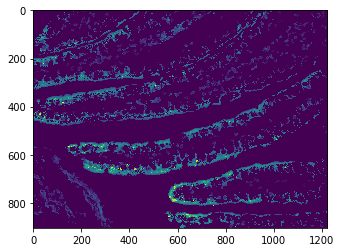

In [131]:
img0_ft=img0.flatten()
img1_ft=img1.flatten()
img2_ft=img2.flatten()
threshold = 30000
fg_condition = (img0_ft+img1_ft+img2_ft>=threshold)
bg_condition = (img0_ft+img1_ft+img2_ft<threshold)
img0_test = img0_ft.copy()
img0_test[bg_condition]=0
plt.imshow(img0_test.reshape(img0.shape[0],img0.shape[1]))
plt.show()

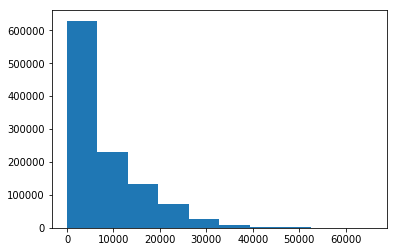

In [127]:
plt.hist(img0_ft)
plt.show()

In [121]:
img0.shape

(904, 1224)

In [138]:
line_count = 0
line_li = []
img_mat = []
with open('/home/yzy/SIMS/slide_1_24_3_20x.txt','r') as f:
    for line in f:
        line_count+=1
        line_li.append(line)
        cur_line=line.split('\t')
        cur_line = list(map(int,cur_line))
        img_mat.append(cur_line)
#         if line_count==10:
#             break

In [139]:
img_name_li=['SI_20x_3color_RFP.txt','SI_20x_3color_GFP.txt','SI_20x_3color_DAPI.txt']
img0 = get_img_mat(img_name_li[0],img_path='/home/yzy/SIMS/')
img1 = get_img_mat(img_name_li[1],img_path='/home/yzy/SIMS/')
img2 = get_img_mat(img_name_li[2],img_path='/home/yzy/SIMS/')

In [175]:
map_img_rgb = img_lab2rgb([img0,img1,img2],10000)

/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 118 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


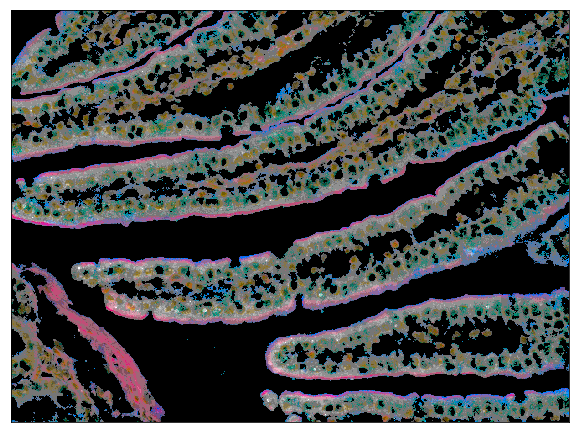

In [176]:
plt.figure(figsize=(10,10))
plt.imshow(map_img_rgb)
plt.xticks([])
plt.yticks([])

plt.show()

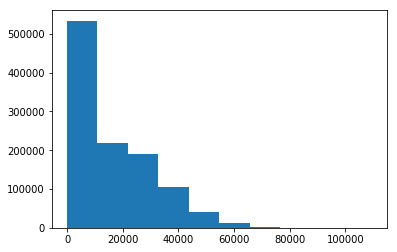

In [145]:
img = img0+img1+img2
plt.hist(img.flatten())
plt.show()

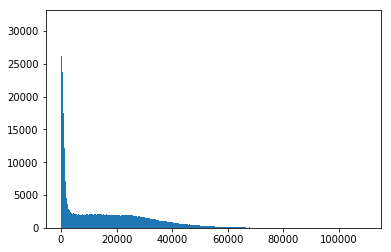

In [146]:
# plt.hist(img0.flatten())
# plt.show()
hist_data = img.flatten()
binwidth = 100
# fig=plt.figure(figsize=(10,10))
plt.hist(hist_data,bins=np.arange(min(hist_data), max(hist_data) + binwidth, binwidth))
# plt.hist(data_134_log,bins=np.arange(min(data_134_log), max(data_134_log) + binwidth, binwidth))
# plt.hist(hist_data)
plt.show()

In [81]:
# bc = PowerTransformer(method='box-cox')
# yj = PowerTransformer(method='yeo-johnson')
qt = QuantileTransformer(output_distribution='normal')

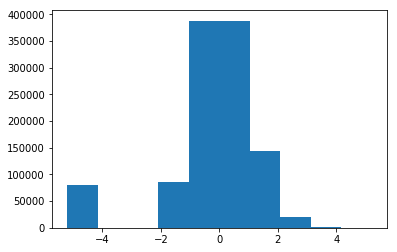

In [83]:
qt_X = qt.fit_transform(hist_data[:,None])
plt.hist(qt_X)
plt.show()

In [97]:
map_img_rgb

array([[[ 0.        ,  0.25075782,  0.7546924 ],
        [ 0.        ,  0.17940096,  0.75557396],
        [ 0.        ,  0.15550326,  0.75579846],
        ..., 
        [ 0.        ,  0.54182463,  1.        ],
        [ 0.        ,  0.54182463,  1.        ],
        [ 0.46632823,  0.46632435,  0.46634423]],

       [[ 0.        ,  0.25075782,  0.7546924 ],
        [ 0.        ,  0.25075782,  0.7546924 ],
        [ 0.        ,  0.19347744,  0.14816164],
        ..., 
        [ 0.        ,  0.54182463,  1.        ],
        [ 0.        ,  0.54182463,  1.        ],
        [ 0.        ,  0.54182463,  1.        ]],

       [[ 0.        ,  0.25075782,  0.7546924 ],
        [ 0.        ,  0.25075782,  0.7546924 ],
        [ 0.        ,  0.19347744,  0.14816164],
        ..., 
        [ 0.35379217,  0.47424533,  0.63178005],
        [ 0.        ,  0.54182463,  1.        ],
        [ 0.        ,  0.54182463,  1.        ]],

       ..., 
       [[ 0.62399428,  0.40359819,  0.46963239],
        

In [ ]:
short_list = [1, 2, 3]
while True:
    value = input('Position [q to quit]?')
    if value == 'q':
        break
    try:
        position = int(value)
        print(short_list[position])
    except IndexError as err:
        print('Bad index:', position)
    except Exception as other:
        print('Something else broke:', other)

In [178]:
1+1

2